In [1]:
from tqdm.notebook import tqdm
from echo_lv.data import LV_EKB_Dataset, LV_CAMUS_Dataset
from echo_lv.lv import cont2area, cart2pol, area2cont, pol2cart, get_contour_points, get_segment_contour, get_main_points, interpolate_contour, sort2d, choose_nearest_to_median
from echo_lv.utils import AverageMeter
from echo_lv.metrics import dice, jaccard

In [2]:
lv_ekb = LV_EKB_Dataset()
lv_camus = LV_CAMUS_Dataset(classes={0, 1})

Dataset is correct.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys

# Проверка преобразования контура в область и область в контур

210
l (359.0, 421.0)
r (469.99999999999994, 441.00000000000006)
l (221.00000000000003, 582.9999999999999)
r (300.0, 568.0)


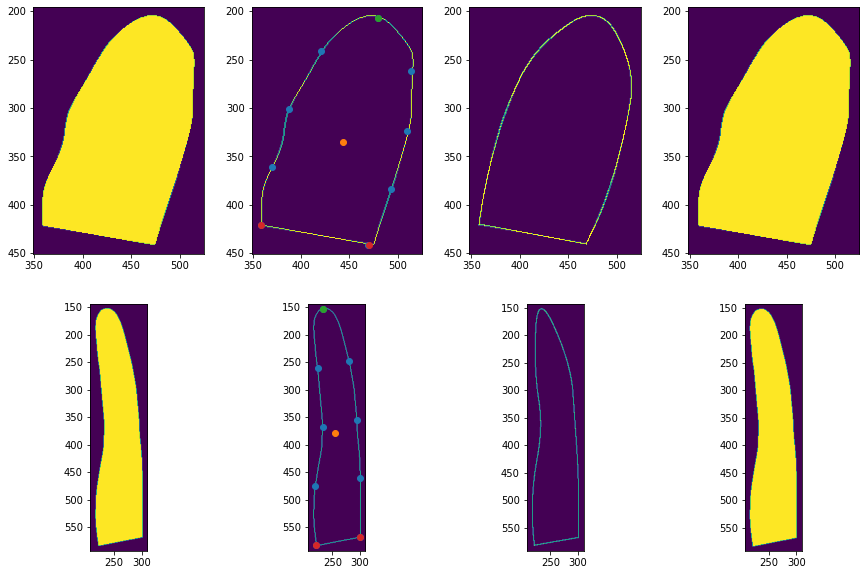

In [4]:
ind = 210
print(ind)
plt.figure(figsize=(15,10))
plt.subplot(241)
plt.imshow(lv_ekb[ind][1])
im = area2cont(lv_ekb[ind][1])
y, x = np.where(im != 0)
kind='contour'
center=None
num=9
apex_point, base_l_point, base_r_point, cent_x, cent_y = get_main_points(im, space='cart')
base_points = [base_l_point, base_r_point]
print('l', base_l_point)
print('r', base_r_point)
cont_x, cont_y, *_ = get_contour_points(im, base_points=base_points, top_point=apex_point, kind=kind, center=center, num=num)
plt.xlim(min(x)-10, max(x)+10)
plt.ylim(min(y)-10, max(y)+10)
plt.gca().invert_yaxis()

plt.subplot(242)
plt.imshow(im)
plt.scatter(cont_x, cont_y)
plt.scatter(cent_x, cent_y)
plt.scatter(apex_point[0], apex_point[1])
plt.scatter([i[0] for i in base_points], [i[1] for i in base_points])
plt.xlim(min(x)-10, max(x)+10)
plt.ylim(min(y)-10, max(y)+10)
plt.gca().invert_yaxis()

plt.subplot(243)
im_pred = np.zeros(im.shape)
x, y = interpolate_contour(cont_x, cont_y, with_base=True)
im_pred[y,x] = 1
plt.imshow(im_pred)
plt.xlim(min(x)-10, max(x)+10)
plt.ylim(min(y)-10, max(y)+10)
plt.gca().invert_yaxis()

plt.subplot(244)
im = cont2area(im)
plt.imshow(im)
plt.xlim(min(x)-10, max(x)+10)
plt.ylim(min(y)-10, max(y)+10)
plt.gca().invert_yaxis()

plt.subplot(245)
plt.imshow(lv_camus[ind][1])


im = area2cont(lv_camus[ind][1])
y, x = np.where(im != 0)
apex_point, base_l_point, base_r_point, cent_x, cent_y = get_main_points(im, space='cart')
base_points = [base_l_point, base_r_point]
print('l', base_l_point)
print('r', base_r_point)
cont_x, cont_y, *_ = get_contour_points(im, base_points=base_points, top_point=apex_point, kind=kind, center=center, num=num)
plt.xlim(min(x)-10, max(x)+10)
plt.ylim(min(y)-10, max(y)+10)
plt.gca().invert_yaxis()

plt.subplot(246)
plt.imshow(im)
plt.scatter(cont_x, cont_y)
plt.scatter(cent_x, cent_y)
plt.scatter(apex_point[0], apex_point[1])
plt.scatter([i[0] for i in base_points], [i[1] for i in base_points])
plt.xlim(min(x)-10, max(x)+10)
plt.ylim(min(y)-10, max(y)+10)
plt.gca().invert_yaxis()

plt.subplot(247)
im_pred = np.zeros(im.shape)
x, y = interpolate_contour(cont_x, cont_y, with_base=True)
im_pred[y,x] = 1
plt.imshow(im_pred)
plt.xlim(min(x)-10, max(x)+10)
plt.ylim(min(y)-10, max(y)+10)
plt.gca().invert_yaxis()

plt.subplot(248)
im = cont2area(im)
plt.imshow(im)
plt.xlim(min(x)-10, max(x)+10)
plt.ylim(min(y)-10, max(y)+10)
plt.gca().invert_yaxis()

14e

In [5]:
# Построение сигнатуры контура

In [265]:
def average_moving(x, n=2):
    avr_x = np.zeros(x.shape)
    if n % 2:
        for i in range(len(x)):
            avr_x[i] = np.mean(x[i - n // 2: i + n // 2])
    else:
        for i in range(len(x)):
            avr_x[i] = np.mean(x[i - n // 2 + 1: i + n // 2])
    return avr_x

def mean_vector(cont_x, cont_y, x_point, y_point):
    vec_x, vec_y = [], []
    for x, y in zip(cont_x - x_point, cont_y - y_point):
        cur_dist = np.linalg.norm((x, y))
        if cur_dist != 0:
            vec_x.append(x / cur_dist)
            vec_y.append(y / cur_dist)
    return np.mean(vec_x), np.mean(vec_y)

def variance_contour(cont_x, cont_y, vec_x, vec_y):
#     mean_vec_x, mean_vec_y = mean_vector(cont_x, cont_y, x_point, y_point)
    var = []
    for x, y in zip(cont_x, cont_y):
        var.append(np.linalg.norm((x - vec_x * (x * vec_x + y * vec_y) / (vec_x**2 + vec_y**2), 
                                   y - vec_y * (x * vec_x + y * vec_y) / (vec_x**2 + vec_y**2))))
        
    return np.mean(var)
    
    
def get_main_points(im, space='cart'):
    '''
    return apex_point, base_left_point, base_right_point
    '''
    im_cont = im.copy()
    im_cont = area2cont(im_cont)
    cont_y, cont_x = np.where(im_cont != 0)
    cent_x, cent_y = np.mean(cont_x), np.mean(cont_y)

    h = 1000
    w = 1000
    k_w = w / im_cont.shape[1]
    k_h = h / im_cont.shape[0]

    new_cont_x, new_cont_y = cont_x * k_w, cont_y * k_h
    cont_phi, cont_rho = cart2pol(new_cont_x, 
                                  new_cont_y, 
                                  np.mean(new_cont_x), 
                                  np.mean(new_cont_y))
    indexes = np.argsort(cont_phi)
    cont_phi = cont_phi[indexes]
    cont_rho = cont_rho[indexes]
    pos_indexes = cont_phi >= 0
    neg_indexes = cont_phi < 0
    index = np.argmax(cont_rho[neg_indexes])
    top_x, top_y = pol2cart(cont_phi[neg_indexes][index], 
                            cont_rho[neg_indexes][index], 
                            np.mean(new_cont_x), 
                            np.mean(new_cont_y))
    dict_base = {}
    for i in range(-100, 101):
        base_phi, base_rho = cart2pol(new_cont_x, 
                                      new_cont_y, 
                                      top_x+i, 
                                      top_y)
    #     plt.scatter(base_phi, base_rho)
        index = np.argmax(base_rho)
        if index in dict_base.keys():
            dict_base[index] += 1
        else:
            dict_base[index] = 1
    
    count = 0        
    for k in dict_base.keys():
        if count < dict_base[k]:
            index = k
            count = dict_base[k]
    print(dict_base)    
    base_x, base_y = new_cont_x[index], new_cont_y[index]
    #pol2cart(base_phi[index], 
          #                    base_rho[index], 
          #                    top_x, 
          #                    top_y)
    
    base_phi, base_rho = cart2pol(base_x, 
                                  base_y, 
                                  np.mean(new_cont_x), 
                                  np.mean(new_cont_y))
    
    check_r_phi = cont_phi[pos_indexes][cont_phi[pos_indexes] < base_phi]
    check_r_rho = cont_rho[pos_indexes][cont_phi[pos_indexes] < base_phi]
    check_l_phi = cont_phi[pos_indexes][cont_phi[pos_indexes] > base_phi]
    check_l_rho = cont_rho[pos_indexes][cont_phi[pos_indexes] > base_phi]
    
    r_x, r_y = pol2cart(check_r_phi, 
                        check_r_rho, 
                        np.mean(new_cont_x), 
                        np.mean(new_cont_y))

    l_x, l_y = pol2cart(check_l_phi, 
                        check_l_rho, 
                        np.mean(new_cont_x), 
                        np.mean(new_cont_y))
    
    plt.scatter(r_x - base_x, r_y - base_y)
#     plt.scatter(l_x - base_x, l_y - base_y)
#     plt.plot([0, r_x[0] - base_x],[0, r_y[0] - base_y])
#     plt.plot([0, l_x[-1] - base_x],[0, l_y[-1] - base_y])

#     num_point = 30
#     lst_var_l, lst_var_r = [], []
#     for num_point in range(1, min(len(r_x), len(l_x))):
                   
#         var_r = variance_contour(r_x[-num_point:], r_y[-num_point:], base_x, base_y)
#         var_l = variance_contour(l_x[:num_point], l_y[:num_point], base_x, base_y)
                   
# #         vec_x, vec_y = mean_vector(r_x[-num_point:], r_y[-num_point:], base_x, base_y)
# #         plt.plot([base_x, base_x + 100*vec_x], [base_y, base_y + 100*vec_y],'r')
# #         vec_x, vec_y = mean_vector(l_x[:num_point], l_y[:num_point], base_x, base_y)
# #         plt.plot([base_x, base_x + 100*vec_x], [base_y, base_y + 100*vec_y],'g')
#         lst_var_l.append(var_l)
#         lst_var_r.append(var_r)
#     plt.subplot(141)
#     plt.plot(range(1,min(len(r_x), len(l_x))), lst_var_l)
# #     plt.ylim(0,1000)
#     plt.subplot(142)
#     plt.plot(range(1,min(len(r_x), len(l_x))), lst_var_r)
# #     plt.ylim(0,1000)
#     plt.subplot(143)
#     plt.plot(np.diff(lst_var_r))
#     plt.plot(np.diff(lst_var_l))
# #     plt.ylim(0,10)
#     plt.subplot(144)
#     plt.scatter(r_x - r_x[0], r_y-r_y[0])
#     plt.scatter(l_x - l_x[-1], l_y - l_y[-1])
#     plt.plot([0, r_x[0] - r_x[-1]], [0, r_y[0] - r_y[-1]])
#     plt.plot([0, l_x[0] - l_x[-1]], [0, l_y[0] - l_y[-1]])
    
#     print(var_l, var_r)

    
#     lst_var_l, lst_var_r = [], []
#     for num_point in range(len(r_x)-10, len(r_x)):         
#         var_r = variance_contour(r_x[-num_point:], r_y[-num_point:], base_x, base_y)
#         lst_var_r.append(var_r)
        
#     for num_point in range(len(l_x)-10, len(l_x)):
#         var_l = variance_contour(l_x[:num_point], l_y[:num_point], base_x, base_y)
#         lst_var_l.append(var_l)
        
#     diff_var_r = np.mean(np.diff(lst_var_r))
#     diff_var_l = np.mean(np.diff(lst_var_l))
#     print(l_x.shape, r_x.shape)
#     print(l_x[0] - l_x[-1], l_y[0] - l_y[-1])
#     print(r_x[0] - r_x[-1], r_y[0] - r_y[-1])
    var_l = variance_contour(l_x - base_x, l_y - base_y, l_x[0] - l_x[-1], l_y[0] - l_y[-1])
    var_r = variance_contour(r_x - base_x, r_y - base_y, r_x[0] - r_x[-1], r_y[0] - r_y[-1])
    length = 10
    var_near_l = variance_contour(l_x[:length] - base_x, l_y[:length] - base_y, l_x[0] - l_x[length-1], l_y[0] - l_y[length-1])
    var_near_r = variance_contour(r_x[-length:] - base_x, r_y[-length:] - base_y, r_x[-1] - r_x[-length], r_y[-1] - r_y[-length])
    base_l_x, base_l_y, base_r_x, base_r_y = None, None, None, None
    print(var_l, var_r)
    print(var_near_l, var_near_r)
    if var_r > var_l:
        check_phi = check_r_phi
        check_rho = check_r_rho
        check_x, check_y = r_x, r_y
        indexes = np.array([i for i, (x, y) in enumerate(zip(check_x, check_y)) if np.linalg.norm((x - base_x, y - base_y)) < 200], dtype=int)
        norm_vec_x, norm_vec_y = mean_vector(np.array(check_x)[indexes], np.array(check_y)[indexes], base_x, base_y)
        norm_vec_x, norm_vec_y = norm_vec_y, -norm_vec_x
        base_l_x, base_l_y = base_x / k_w, base_y / k_h
        edge_x, edge_y = check_x[0], check_y[0]
    else:
        check_phi = check_l_phi
        check_rho = check_l_rho
        check_x, check_y = l_x, l_y
        indexes = np.array([i for i, (x, y) in enumerate(zip(check_x, check_y)) if np.linalg.norm((x - base_x, y - base_y)) < 200], dtype=int)
        norm_vec_x, norm_vec_y = mean_vector(np.array(check_x)[indexes], np.array(check_y)[indexes], base_x, base_y)
        norm_vec_x, norm_vec_y = -norm_vec_y, norm_vec_x
        base_r_x, base_r_y = base_x / k_w, base_y / k_h
        edge_x, edge_y = check_x[-1], check_y[-1]
    
#     print(base_x, base_y)
#     plt.scatter(base_x / k_w, base_y / k_h)
    k = 10
    c_x, c_y = base_x + k * norm_vec_x, base_y + k * norm_vec_y
    while np.linalg.norm((c_x - base_x, c_y - base_y)) <= np.linalg.norm((edge_x - c_x, edge_y - c_y)) or c_y > top_y:
        if k > 1000:
            break
        k += 1
        c_x, c_y = base_x + k * norm_vec_x, base_y + k * norm_vec_y
#         plt.scatter(c_x / k_w, c_y / k_h)
    
    check_phi, check_rho = cart2pol(check_x, 
                                    check_y,
                                    c_x,
                                    c_y,
                                   )
        
#     plt.scatter(check_x, check_y)
#     plt.scatter(edge_x, edge_y)
#     plt.scatter(base_r_x, base_r_y)
#     plt.scatter(c_x / k_w, c_y / k_h)
#     print(np.linalg.norm((c_x - base_x, c_y - base_y)), np.linalg.norm((edge_x - c_x, edge_y - c_y)))
#     print(edge_x, edge_y)
    print(k)
   
    check_phi[check_phi <= -np.pi/2] += 2*np.pi
    
#     plt.scatter(check_phi, check_rho)
    index = np.argmax(check_rho)
    base_x, base_y = check_x[index], check_y[index]

    if base_r_x is None and base_r_y is None:
        base_r_x, base_r_y = base_x / k_w, base_y / k_h

    elif base_l_x is None and base_l_y is None:
        base_l_x, base_l_y = base_x / k_w, base_y / k_h
    
    cont_phi, cont_rho = cart2pol(cont_x, cont_y, (base_l_x + base_r_x) / 2, (base_l_y + base_r_y) / 2)
    index = np.argmax(cont_rho)
    apex_phi, apex_rho = cont_phi[index], cont_rho[index]
    apex_x, apex_y = pol2cart(apex_phi, 
                              apex_rho, 
                              (base_l_x + base_r_x) / 2, 
                              (base_l_y + base_r_y) / 2)
        
    
    if space == 'polar':
        apex_phi, apex_rho = cart2pol(apex_x, 
                                      apex_y, 
                                      cent_x, 
                                      cent_y)
        base_l_phi, base_l_rho = cart2pol(base_r_x, 
                                          base_r_y, 
                                          cent_x, 
                                          cent_y)
        base_r_phi, base_r_rho = cart2pol(base_l_x, 
                                          base_l_y, 
                                          cent_x, 
                                          cent_y)
        return (apex_phi, apex_rho), (base_l_phi, base_l_rho), (base_r_phi, base_r_rho), cent_x, cent_y
    elif space == 'cart':
        return (apex_x, apex_y), (base_l_x, base_l_y), (base_r_x, base_r_y), cent_x, cent_y
    else:
        return

1388
{176: 35, 192: 87, 188: 79}
7.566955791062754 25.260345754037143
9.516772364674539 2.5383654128340702
512


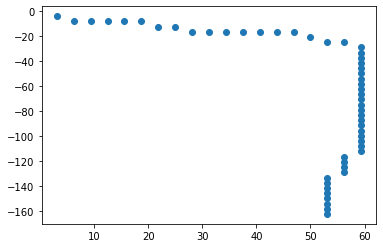

In [266]:
data = lv_camus
ind = 1259#150#917#616#1050#879#1329#944#367#1088#78#73#447#927#
data = lv_ekb
ind = 1388#2461#1743#2112
print(ind)
im_area = data[ind][1]
im_cont = area2cont(im_area)
apex_point, base_l_point, base_r_point, *_ = get_main_points(im_cont, space='cart')
# plt.imshow(im_cont)
# plt.scatter(apex_point[0], apex_point[1])
# plt.scatter(base_l_point[0], base_l_point[1])
# plt.scatter(base_r_point[0], base_r_point[1])

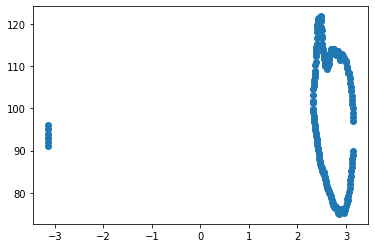

In [248]:
y, x = np.where(im_cont != 0)
phi, rho = cart2pol(x, y, np.mean(x), np.mean(y))
index = np.argmax(rho)
phi, rho = cart2pol(x, y, x[index]+100, y[index])
plt.scatter(phi, rho)


In [87]:
print(base_l_point, base_r_point)

(338.0, 621.0) (403.0, 623.9999999999999)


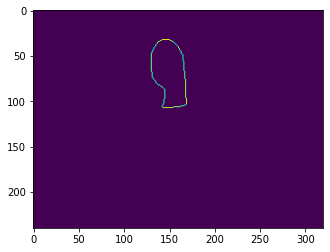

In [68]:
plt.imshow(im_cont)

In [1]:
data = lv_ekb
ind = 1688
print(ind)
im_area = data[ind][1]
im_cont = area2cont(im_area)
apex_point, base_l_point, base_r_point, *_ = get_main_points(im_cont, space='cart')

NameError: name 'lv_ekb' is not defined

(220.0, 270.0)

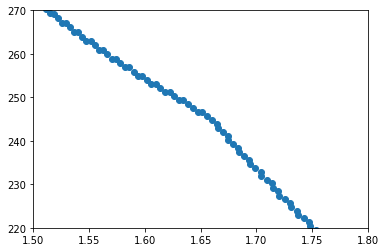

In [44]:
y, x = np.where(im_cont != 0)
phi, rho = cart2pol(x, y, np.mean(x), np.mean(y))
plt.scatter(phi, rho)
plt.xlim(1.5, 1.8)
plt.ylim(220, 270)

In [17]:
apex_point, base_l_point, base_r_point

((251.0, 209.99999999999997), (315.0, 750.0), (321.0, 752.9999999999999))

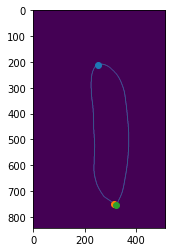

In [18]:
plt.imshow(im_cont)
plt.scatter(apex_point[0], apex_point[1])
plt.scatter(base_l_point[0], base_l_point[1])
plt.scatter(base_r_point[0], base_r_point[1])
cont_x, cont_y, *_ = get_contour_points(im_cont, 
                                    base_points=[base_l_point, base_r_point], 
                                    top_point=apex_point,
                                    space='cart',
                                    kind='contour',
                                    center=None,
                                    num=9,
                                   ) 
#plt.scatter(cont_x, cont_y)
# plt.xlim(270,280)
# plt.ylim(720,730)
# plt.xlim(250,300)
# plt.ylim(700,750)

In [ ]:
center = None
kind = 'contour'
list_bases_camus = []
list_tops_camus = []
for ind in tqdm(range(0,len(lv_camus)), total=len(lv_camus)):
    im_area = lv_camus[ind][1]
    im_cont = area2cont(im_area)
    top_point, base_l_point, base_r_point, *_ = get_main_points(im_cont, space='cart')
    base_points = [base_l_point, base_r_point]
    list_bases_camus.append(base_points)
    list_tops_camus.append(top_point)

0.6923391536888469 1088


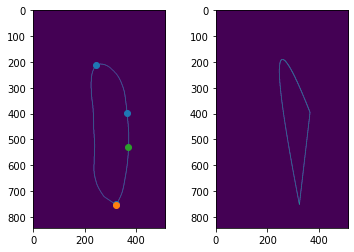

In [91]:

data = lv_camus
ind = 67
ind=1088


im_area = data[ind][1]
im_cont = area2cont(im_area)
apex_point, base_l_point, base_r_point, *_ = get_main_points(im_cont, space='cart')
base_points = [base_l_point, base_r_point]
cont_x, cont_y, cent_x, cent_y = get_contour_points(im_cont, base_points=base_points, top_point=apex_point, kind='contour', center=None, num=3)
plt.subplot(121)
plt.imshow(im_cont)
plt.scatter(cont_x, cont_y)
plt.scatter(base_l_point[0], base_l_point[1])
plt.scatter(base_r_point[0], base_r_point[1])
# plt.xlim(0.1, 0.3)
# plt.ylim(0.1, 0.3)

local_cont_x, local_cont_y = interpolate_contour(cont_x, cont_y, with_base=True, k=2)
im_pred = np.zeros(im_cont.shape, dtype=bool)
im_pred[local_cont_y.astype(int), local_cont_x.astype(int)] = True

plt.subplot(122)
plt.imshow(im_pred)
im_pred = cont2area(im_pred)
coef = dice(im_area, im_pred)


print(coef, ind)

In [22]:
cont_x

array([246, 202, 198, 198, 182, 166, 170, 189, 249, 303, 351, 364, 367,
       367, 335], dtype=uint16)

In [12]:
cont_y

array([705, 651, 585, 519, 455, 389, 324, 258, 228, 274, 342, 416, 485,
       544, 312], dtype=uint16)

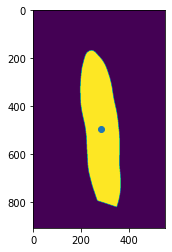

In [267]:
ind = 822
plt.imshow(lv_camus[ind][1])
cont_y, cont_x = np.where(lv_camus[ind][1] != 0)
plt.scatter(np.mean(cont_x), np.mean(cont_y))

In [6]:
list_bases_camus = []
for ind in tqdm(range(0,len(lv_camus)), total=len(lv_camus)):
    im_area = lv_camus[ind][1]
    im_cont = area2cont(im_area)
    top_point, base_l_point, base_r_point, *_ = get_main_points(im_cont, space='cart')
    base_points = [base_l_point, base_r_point]
    list_bases_camus.append(base_points)

KeyboardInterrupt: 

In [29]:
dices_camus = {}
jaccards_camus = {}
for num_points in range(3, 4):
    dices = []
    jaccards = []
    for ind in tqdm(range(0,len(lv_camus)), total=len(lv_camus), desc=str(num_points)):
        im_area = lv_camus[ind][1]
        im_cont = area2cont(im_area)
        cont_x, cont_y, *_ = get_contour_points(im_cont, base_points=None, space='cart', num=num_points, kind='contour', center=None)
        im_pred = np.zeros(im_cont.shape)
        x, y = interpolate_contour(cont_x, cont_y, with_base=True)
        im_pred[y,x] = 1
        
        dices.append(dice(im_area, cont2area(im_pred)))
        jaccards.append(jaccard(im_area, cont2area(im_pred)))
        
    dices_camus[num_points] = dices
    jaccards_camus[num_points] = jaccards

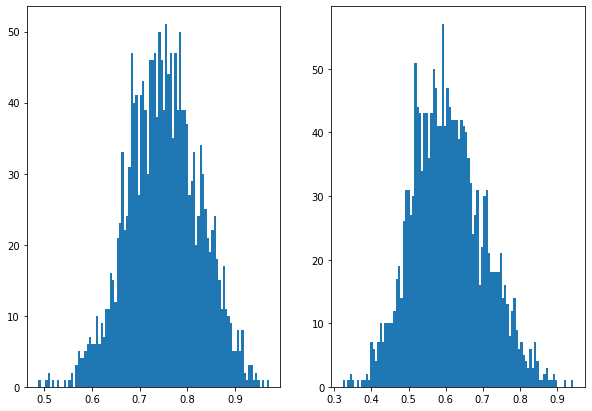

In [ ]:
plt.figure(figsize=(10,7))
plt.subplot(121)
plt.hist(dices_camus[num_points], bins=100);
plt.subplot(122)
plt.hist(jaccards_camus[num_points], bins=100);

In [7]:
np.argsort(dices_camus[num_points])[:10]

array([1688, 1359,  632, 1035, 1083,  200, 1539,  290, 1029,  618])

SyntaxError: can't use starred expression here (<ipython-input-8-e61ef3ef6758>, line 4)

In [134]:
import pandas as pd
dfs_ekb = pd.read_excel('quartile_ekb.xlsx', sheet_name=0)
dfs_camus = pd.read_excel('quartile_camus.xlsx', sheet_name=0)

In [142]:
dfs_ekb.columns

Index([      'dice',         0.05,          0.5,         0.95, 'Unnamed: 4',
       'Unnamed: 5',    'jaccard',     '0.05.1',      '0.5.1',     '0.95.1'],
      dtype='object')

A=0.2674551814617982
h=-0.7670141360929877
b=1.9930631158687062
l=1.0155568537903659


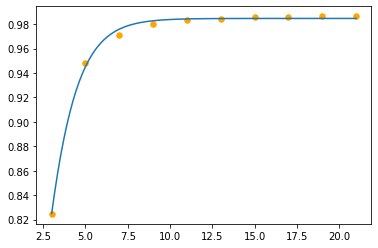

In [236]:
from scipy.optimize import curve_fit

def func(t, A, h, b, l):
    return 1 / (l + A * np.exp(h*t + b))

# t = np.array([1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016])
# y = np.array([1,-7.9,2.8,3.2,2.2,3.9,2.7,2.5,6.2,5.7,3.6,3.2,-0.4,5.6,3.3,3,2.6,5.9,-2.3,-1.1])

popt, pcov = curve_fit(func, n_points, ekb_dice_quart_50, (0.1, 0.5, 1, 1), maxfev=10**6)    
A, h, b, l = popt

print('A={0}\nh={1}\nb={2}\nl={3}'.format(*tuple(popt)))

plt.scatter(n_points, ekb_dice_quart_50, s=30, color='orange')
plt.plot(np.linspace(3,21,100), func(np.linspace(3,21,100), *popt))

t = np.linspace(0,21,100)
# plt.plot(t, 1 - 1 / (1 + np.exp(t)))

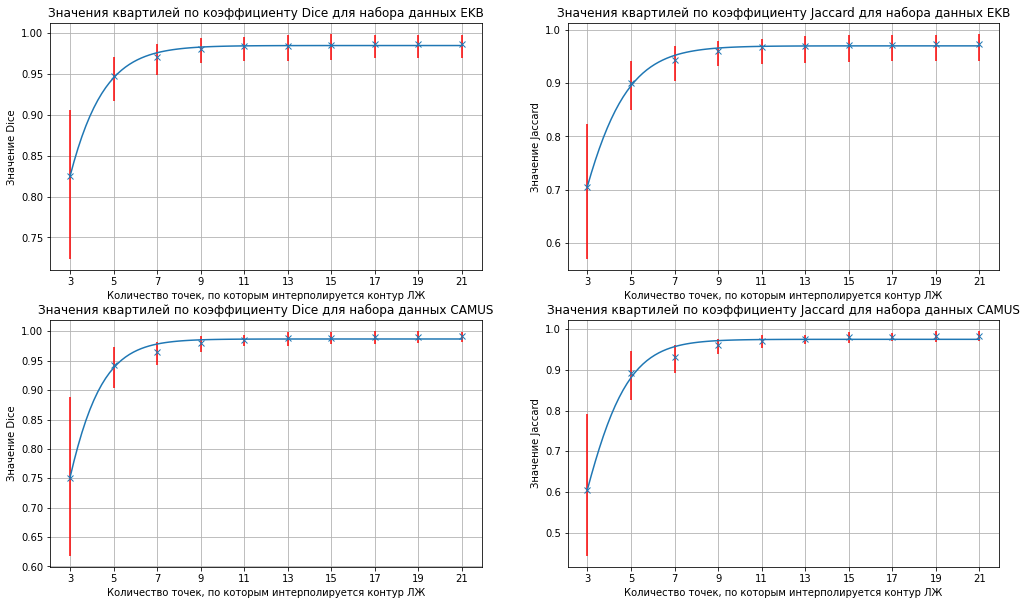

In [243]:
def func(t, A, h, b, l):
    return 1 / (l + A * np.exp(h*t + b))

popt, pcov = curve_fit(func, n_points, ekb_dice_quart_50, (0, 0.5, 1, 1), maxfev=10**8)    
A, h, b, l = popt

# print('A={0}\nh={1}\nb={2}\nl={3}'.format(*tuple(popt)))

# plt.scatter(n_points, ekb_dice_quart_50, s=30, color='orange')
# plt.plot(np.linspace(3,21,100), func(np.linspace(3,21,100), *popt))

n_points = np.arange(3, 22, 2)
ekb_dice_quart_5 = np.array(dfs_ekb[0.05])
ekb_dice_quart_50 = np.array(dfs_ekb[0.5])
ekb_dice_quart_95 = np.array(dfs_ekb[0.95])
ekb_jaccard_quart_5 = np.array(dfs_ekb['0.05.1'])
ekb_jaccard_quart_50 = np.array(dfs_ekb['0.5.1'])
ekb_jaccard_quart_95 = np.array(dfs_ekb['0.95.1'])
camus_dice_quart_5 = np.array(dfs_camus[0.05])
camus_dice_quart_50 = np.array(dfs_camus[0.5])
camus_dice_quart_95 = np.array(dfs_camus[0.95])
camus_jaccard_quart_5 = np.array(dfs_camus['0.05.1'])
camus_jaccard_quart_50 = np.array(dfs_camus['0.5.1'])
camus_jaccard_quart_95 = np.array(dfs_camus['0.95.1'])
plt.figure(figsize=(17,10))
plt.subplot(221)
plt.errorbar(n_points, 
             ekb_dice_quart_50, 
             yerr=np.concatenate((np.expand_dims(ekb_dice_quart_50 - ekb_dice_quart_5, axis=0), 
                                  np.expand_dims(ekb_dice_quart_95 - ekb_dice_quart_50, axis=0)), axis=0),
             marker='x',
             ecolor='r',
             ls=''
            )
popt, pcov = curve_fit(func, n_points, ekb_dice_quart_50, (0.1, 0.5, 1, 1), maxfev=10**6)
plt.plot(np.linspace(3,21,100), func(np.linspace(3,21,100), *popt))
plt.xticks(n_points);
plt.grid('on')
plt.xlabel('Количество точек, по которым интерполируется контур ЛЖ')
plt.ylabel('Значение Dice')
plt.title('Значения квартилей по коэффициенту Dice для набора данных EKB')
plt.subplot(222)
plt.errorbar(n_points, 
             ekb_jaccard_quart_50, 
             yerr=np.concatenate((np.expand_dims(ekb_jaccard_quart_50 - ekb_jaccard_quart_5, axis=0), 
                                  np.expand_dims(ekb_jaccard_quart_95 - ekb_jaccard_quart_50, axis=0)), axis=0),
             marker='x',
             ecolor='r',
             ls=''
            )
popt, pcov = curve_fit(func, n_points, ekb_jaccard_quart_50, (0.1, 0.5, 1, 1), maxfev=10**6)
plt.plot(np.linspace(3,21,100), func(np.linspace(3,21,100), *popt))
plt.xticks(n_points);
plt.grid('on')
plt.xlabel('Количество точек, по которым интерполируется контур ЛЖ')
plt.ylabel('Значение Jaccard')
plt.title('Значения квартилей по коэффициенту Jaccard для набора данных EKB')
plt.subplot(223)
plt.errorbar(n_points, 
             camus_dice_quart_50, 
             yerr=np.concatenate((np.expand_dims(camus_dice_quart_50 - camus_dice_quart_5, axis=0), 
                                  np.expand_dims(camus_dice_quart_95 - camus_dice_quart_50, axis=0)), axis=0),
             marker='x',
             ecolor='r',
             ls=''
            )
popt, pcov = curve_fit(func, n_points, camus_dice_quart_50, (0.1, 0.5, 1, 1), maxfev=10**6)
plt.plot(np.linspace(3,21,100), func(np.linspace(3,21,100), *popt))
plt.xticks(n_points);
plt.grid('on')
plt.xlabel('Количество точек, по которым интерполируется контур ЛЖ')
plt.ylabel('Значение Dice')
plt.title('Значения квартилей по коэффициенту Dice для набора данных CAMUS')
plt.subplot(224)
plt.errorbar(n_points, 
             camus_jaccard_quart_50, 
             yerr=np.concatenate((np.expand_dims(camus_jaccard_quart_50 - camus_jaccard_quart_5, axis=0), 
                                  np.expand_dims(camus_jaccard_quart_95 - camus_jaccard_quart_50, axis=0)), axis=0),
             marker='x',
             ecolor='r',
             ls=''
            )
popt, pcov = curve_fit(func, n_points, camus_jaccard_quart_50, (0.1, 0.5, 1, 1), maxfev=10**6)
plt.plot(np.linspace(3,21,100), func(np.linspace(3,21,100), *popt))
plt.xticks(n_points);
plt.grid('on')
plt.xlabel('Количество точек, по которым интерполируется контур ЛЖ')
plt.ylabel('Значение Jaccard')
plt.title('Значения квартилей по коэффициенту Jaccard для набора данных CAMUS')
plt.savefig('quartiles_graphics.png', dpi =300, bbox_inches='tight', pad_inches=0)